In [1]:
import bisect
import pickle
from collections import Counter

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Charge les référentiels
cf `referentiels.py`

In [2]:
ROME_df = pd.read_csv('../referentiels/referentiel_ROME/20150921_arboprincipale28427_ROME.csv', index_col=0, sep='|', dtype=str)
OGR_df = pd.read_csv('../referentiels/referentiel_OGR/20150921_arboprincipale28427_OGR.csv', sep='|', dtype=str).set_index('OGR')
NAF_df = pd.read_csv('../referentiels/referentiel_NAF/naf2008_liste_n5_nouveau_header.csv', sep='|', encoding="utf-8").set_index(['NAF'])

In [3]:
tranches_effectif = ['00', '01', '02', '03', '11', '12', '21', '22', '31', '32', '41', '42', '51', '52', '53', 'NN']
seuils_tranches_effectif = [0, 1, 3, 6, 10, 20, 50, 100, 200, 250, 500, 1000, 2000, 5000, 10000]

In [4]:
def trouve_tranche_effectif(effectif):
    index = bisect.bisect(seuils_tranches_effectif, effectif) - 1
    return index, tranches_effectif[index]

# Charge les DPAE

In [5]:
filename = '../LBB_ETT_ETT_20160430_20170530_20170530_162434_clean.csv'

In [6]:
df = pd.read_csv(filename, sep='|', dtype=str, keep_default_na=False)

# Histogramme sur la durée

In [7]:
duree_liste = list(df.dn_nbjcaltotalmission)

In [8]:
duree_liste = [int(duree) for duree in duree_liste if duree != 'NULL']

In [9]:
comptage_duree = Counter(duree_liste)

In [10]:
duree_max = max(comptage_duree.keys())
duree_max

365

In [11]:
histo = [comptage_duree[i] for i in range(duree_max + 1)]
sum(histo), sum(histo[30:])

(15339856, 1066312)

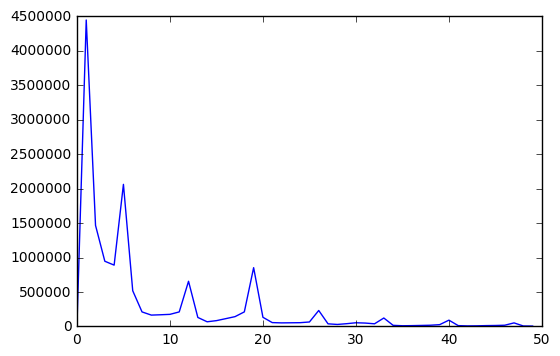

In [12]:
plt.plot(histo[:50])

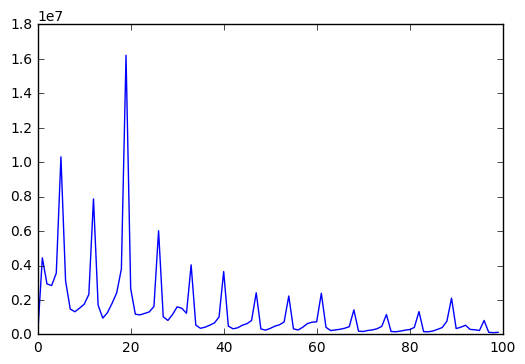

In [13]:
volume = [histo[i]*i for i in range(duree_max + 1)]
plt.plot(volume[:100])

In [14]:
sum(volume), sum(volume[30:]), float(sum(volume[30:]))/sum(volume)

(152336029, 62580705, 0.4108069864417957)

# Array : ROME x NAF x effectif

In [15]:
def ponderation_duree(nbrjourtravaille, dn_nbmission):
    return 1 if (int(nbrjourtravaille) * int(dn_nbmission) >=30) else 0
        

In [16]:
n_NAF = len(NAF_df)
n_ROME = len(ROME_df)
n_tranches = len(tranches_effectif)

array_ROME1 = np.zeros((n_NAF, n_ROME, n_tranches))
array_ROME2 = np.zeros((n_NAF, n_ROME, n_tranches))


In [17]:
for i, row in df.iterrows():
    (dn_nbjcaltotalmission, dc_nafinsee700_id, dn_nbmission,
    dc_nafrefv2_id, dc_trancheeffectif_id, dc_romev3_1_id,
    dc_romev3_2_id) = row
    
    if ((dn_nbjcaltotalmission != 'NULL') and (dc_nafrefv2_id in NAF_df.index) and
        (dc_romev3_1_id in ROME_df.index)):
        
        NAF_index = NAF_df.index.get_loc(dc_nafrefv2_id)
        ROME_index = ROME_df.index.get_loc(dc_romev3_1_id)
        
        try:
            effectif = int(dc_trancheeffectif_id)
        except ValueError:
            tranche = 'NA'
            tranche_index = 15
        else:
            tranche_index, tranche = trouve_tranche_effectif(effectif)
            
        poids = ponderation_duree(dn_nbjcaltotalmission, dn_nbmission)
        
        array_ROME1[NAF_index, ROME_index, tranche_index] += poids

        if dc_romev3_2_id in ROME_df.index:
            ROME2_index = ROME_df.index.get_loc(dc_romev3_2_id)
            array_ROME2[NAF_index, ROME2_index, tranche_index] += poids
        
    if i % 100000 == 0:
        print(i)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000

In [18]:
with open('../array_ROME1_ETT.pickle', 'wb') as f:
    pickle.dump(array_ROME1, f)

In [19]:
with open('../array_ROME2_ETT.pickle', 'wb') as f:
    pickle.dump(array_ROME2, f)